In [1]:

import nltk
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to C:\Users\Emmanuel
[nltk_data]     Djaba\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package wordnet to C:\Users\Emmanuel
[nltk_data]     Djaba\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
from textblob import TextBlob
import pandas as pd
pd.set_option('display.max_colwidth', None)
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np

## Data Prepration

In [3]:
#Load text and labels
train_text = pd.read_csv('dataset/offensive_train_text.txt', delimiter = "\t",header=None,names=["Text"])
train_labels = pd.read_csv('dataset/offensive_train_labels.txt', delimiter = "\t",header=None,names=["Label"])

In [4]:
#combine text and labels into one dataset
dataset = pd.concat([train_text,train_labels],axis=1)

In [5]:
dataset.head(5)

,Text,Label
0,back off,1
1,baseball was horrible,1
2,"don't come to school, will kill you",1
3,go kill yourself,1
4,haha,1


### Generate tokens out of the text

In [6]:
#create an empty column to store the tokens
dataset["Tokens"] = None

In [7]:
#generate tokens for each line of text
for ind in dataset.index:
    words = TextBlob(dataset["Text"][ind]).words
    # remove punctuation from each word
    words = [word for word in words if word.isalpha()]
    dataset["Tokens"][ind] = words

In [8]:
dataset.tail(5)

,Text,Label,Tokens
120,you silly,1,"[you, silly]"
121,you suck so much,1,"[you, suck, so, much]"
122,you're ugly and fat,1,"[you, ugly, and, fat]"
123,you're ugly and stupid,1,"[you, ugly, and, stupid]"
124,you make me laugh a lot,0,"[you, make, me, laugh, a, lot]"


### Reduce each word to its root via lemmatization

In [9]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

In [10]:
#create an empty column to store the cleaned words
dataset["Cleaned"] = None

In [11]:
#generate tokens for each line of text
for ind in dataset.index:
    tokens = dataset["Tokens"][ind]
    cleaned_words = []
    for token in tokens:
        cleaned_words.append(lemmatizer.lemmatize(token))
    dataset["Cleaned"][ind] = cleaned_words

In [12]:
dataset.tail(5)

,Text,Label,Tokens,Cleaned
120,you silly,1,"[you, silly]","[you, silly]"
121,you suck so much,1,"[you, suck, so, much]","[you, suck, so, much]"
122,you're ugly and fat,1,"[you, ugly, and, fat]","[you, ugly, and, fat]"
123,you're ugly and stupid,1,"[you, ugly, and, stupid]","[you, ugly, and, stupid]"
124,you make me laugh a lot,0,"[you, make, me, laugh, a, lot]","[you, make, me, laugh, a, lot]"


### Generate vector for classification

In [13]:
#create sentences from stemmed tokens 
np_docs = []
for ind in dataset.index:
    res = ' '.join(dataset['Cleaned'][ind])
    np_docs.append(res)

In [14]:
#fit tfidf
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=10)
doc_vec = vectorizer.fit(np_docs)

In [15]:
#create an empty column to store TFIDF
dataset["TFIDF"] = None

In [16]:
for ind in dataset.index:
    dataset["TFIDF"][ind] = vectorizer.transform(dataset["Cleaned"][ind]).toarray()[0]

In [17]:
dataset.head(2)

,Text,Label,Tokens,Cleaned,TFIDF
0,back off,1,"[back, off]","[back, off]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
1,baseball was horrible,1,"[baseball, was, horrible]","[baseball, wa, horrible]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"


## Build models

In [18]:
from sklearn import model_selection, naive_bayes, svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

In [19]:
#gather features
features = []
for ind in dataset.index:
    features.append(dataset['TFIDF'][ind])

In [20]:
#because we have only one feature   
for f in features:
    f = f.reshape(-1,1)

features[0].shape

(10,)

In [21]:
labels = []
for ind in dataset.index:
    labels.append(dataset['Label'][ind])

### Visualize features

In [22]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

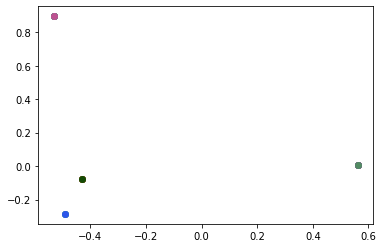

In [23]:
pca = PCA(n_components=2).fit(features)
data2D = pca.transform(features)
x_coordinates = data2D[:,0]
y_coordinates =  data2D[:,1]
                
for x, y in zip(x_coordinates, y_coordinates):
    rgb = np.random.rand(3,)
    plt.scatter(x, y, c=[rgb])
plt.show()      

In [24]:
#create train and test splits
Train_X, Test_X, Train_Y, Test_Y = model_selection.train_test_split(features,labels,test_size=0.3)

In [25]:
# function to prepare  input
def prepare_input(sample_text):
    words = TextBlob(sample_text).words
    # remove punctuation from each word
    words = [word for word in words if word.isalpha()]
    cleaned_words = []
    for word in words:
        cleaned_words.append(lemmatizer.lemmatize(word))
    return vectorizer.transform(cleaned_words).toarray()[0]

### KNN Model

In [26]:
neigh_model = KNeighborsClassifier(n_neighbors=1)
neigh_model.fit(Train_X, Train_Y)

KNeighborsClassifier(n_neighbors=1)

In [27]:
predictions_neigh = neigh_model.predict(Test_X)
print("Nearest Neighbors Accuracy Score -> ",accuracy_score(predictions_neigh, Test_Y)*100)

Nearest Neighbors Accuracy Score ->  100.0


In [28]:
#insert test text here
test_text = "I have so much homework im going to die"

In [29]:
test_input = prepare_input(test_text).reshape(1, -1)
predicted_value = neigh_model.predict(test_input)[0]

In [30]:
predicted_value

1